# **Clasificación de Radiografías Musculoesqueléticas (MURA)**

Este proyecto tiene como objetivo desarrollar un modelo de **clasificación binaria** capaz de identificar si una radiografía musculoesquelética (perteneciente al conjunto de datos [MURA](https://stanfordmlgroup.github.io/competitions/mura/)) presenta una **anomalía (abnormal)** o es **normal (negative)**.

---

## ¿Qué haremos?

1. **Prepararemos los datos** a partir de las imágenes del dataset MURA.
2. **Crearemos un modelo basado en ResNet18 preentrenado**, adaptado para clasificación binaria.
3. **Entrenaremos** el modelo sobre las radiografías con técnicas de fine-tuning.
4. **Evaluaremos su rendimiento** con métricas como F1-score, accuracy y matriz de confusión.
5. **Visualizaremos predicciones correctas y errores** para interpretar el comportamiento.
6. **Guardaremos el modelo final** para uso futuro.

## **Paso 1: Importaciones y librerías necesarias**

A continuación, cargamos todas las librerías necesarias para procesamiento de imágenes, modelado con PyTorch, visualización y evaluación.

In [7]:
# Librerías de procesamiento y visualización
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import random

# PyTorch y herramientas para modelado
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Guardado de modelo
import joblib

##  **Paso 2: Configuración e Hiperparámetros**

En este bloque definimos los valores clave para entrenar nuestro modelo:
- Ruta del dataset MURA completo (guardado en local debido al peso)
- Tamaño de imagen y lote
- Número de épocas
- Learning rate
- Patiencia para early stopping y reducción de LR

In [2]:
# Ruta al dataset MURA completo
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"
train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "valid")

# Dispositivo (GPU si está disponible)
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Computando en:", DEVICE)

# Tamaño de imagen
IMAGE_SIZE = (224, 224)

# Hiperparámetros
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
EARLYSTOP_PATIENCE = 5
LR_PATIENCE = 5
WEIGHT_DECAY = 1e-4  # Regularización L2 para evitar overfitting

# Ruta donde se guardará el modelo final
MODEL_PATH = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model.pkl"

Computando en: mps


## **Paso 3: Transformaciones, creación del Dataset y DataLoaders**

Para entrenar un modelo robusto, es crucial preparar adecuadamente los datos. En este paso:

- Aplicaremos **transformaciones de aumento de datos (data augmentation)** al conjunto de entrenamiento para mejorar la capacidad de generalización del modelo.
- Estandarizaremos todas las imágenes al mismo tamaño (`224x224`) y normalizaremos con la media y desviación estándar de ImageNet (ya que la ResNet fue preentrenada con este dataset).
- Crearemos los `DataLoader` de entrenamiento y validación para facilitar la iteración por lotes durante el entrenamiento.

Además, incluimos un pequeño análisis para detectar posibles problemas de estructura de carpetas o archivos ocultos.

In [3]:
# ---------------------------
# Transformaciones de imágenes
# ---------------------------

# Transformaciones para el conjunto de entrenamiento
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                      # Redimensiona todas las imágenes a 224x224 píxeles
    transforms.RandomHorizontalFlip(),                 # Aplica un flip horizontal aleatorio (50% de probabilidad)
    transforms.RandomRotation(degrees=10),             # Rota aleatoriamente las imágenes entre -10 y 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Ajustes aleatorios de brillo y contraste
    transforms.ToTensor(),                             # Convierte la imagen PIL a tensor (necesario para PyTorch)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # Normaliza con los valores de la media y desviación
                         std=[0.229, 0.224, 0.225])     # usados en los modelos preentrenados de ImageNet
])

# Transformaciones para el conjunto de validación (sin augmentación)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---------------------------------------------
# Dataset personalizado: MURABinaryDataset
# ---------------------------------------------
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        root_dir = Path(root_dir)

        # Recorrido por cada parte del cuerpo (e.g. XR_HAND, XR_WRIST...)
        for body_part in root_dir.iterdir():
            if not body_part.is_dir() or body_part.name.startswith('.'):
                continue  # Saltar archivos ocultos como .DS_Store

            for patient_dir in body_part.iterdir():
                if not patient_dir.is_dir():
                    continue

                for study_dir in patient_dir.iterdir():
                    if not study_dir.is_dir():
                        continue

                    # Asignación binaria: 0 (negativa), 1 (positiva)
                    label = 1 if "positive" in study_dir.name else 0

                    # Añadir todas las imágenes del estudio a la lista de muestras
                    for img_path in study_dir.glob("*.png"):
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")  # Asegurarse de que todas las imágenes tengan 3 canales
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------------------
# Carga de los datasets
# ---------------------------

# Se crean los datasets personalizados con las transformaciones adecuadas
train_dataset = MURABinaryDataset(train_dir, transform=transform_train)
valid_dataset = MURABinaryDataset(valid_dir, transform=transform_val)

# ---------------------------
# Creación de los DataLoaders
# ---------------------------

# DataLoader para entrenamiento (mezcla aleatoriamente las imágenes)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# DataLoader para validación (no se mezcla, se mantienen en orden)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verificación del tamaño de los datasets
print(f"Dataset cargado: {len(train_dataset)} entrenamiento, {len(valid_dataset)} validación")

Dataset cargado: 36808 entrenamiento, 3197 validación


Se han detectado **36,808 imágenes de entrenamiento** y **3,197 de validación**, lo cual indica una partición saludable del dataset. Este volumen de datos es suficiente para entrenar modelos de Deep Learning como ResNet18 con un buen rendimiento.

Además, se implementa el control de calidad eliminando archivos ocultos (`.DS_Store`) y asegurando que todas las imágenes tengan formato RGB, lo cual es fundamental para trabajar con modelos preentrenados en ImageNet.

## **Paso 4: Análisis del desequilibrio de clases**

Antes de entrenar el modelo, es crucial analizar la distribución de las clases en el conjunto de entrenamiento.  
En este problema, queremos clasificar radiografías como **normales (0)** o **anormales (1)**.  
Si hay una diferencia significativa entre el número de imágenes por clase, el modelo podría sesgarse hacia la clase mayoritaria.

En este paso:

- Calcularemos cuántas imágenes hay de cada clase.
- Visualizaremos esa distribución.
- Calcularemos **pesos inversamente proporcionales** al número de muestras por clase para equilibrar la función de pérdida (`CrossEntropyLoss`), de forma que el modelo aprenda sin favorecer la clase dominante.

Distribución de clases en el conjunto de entrenamiento:
Clase 0 (Normal (0)): 21935 ejemplos
Clase 1 (Abnormal (1)): 14873 ejemplos


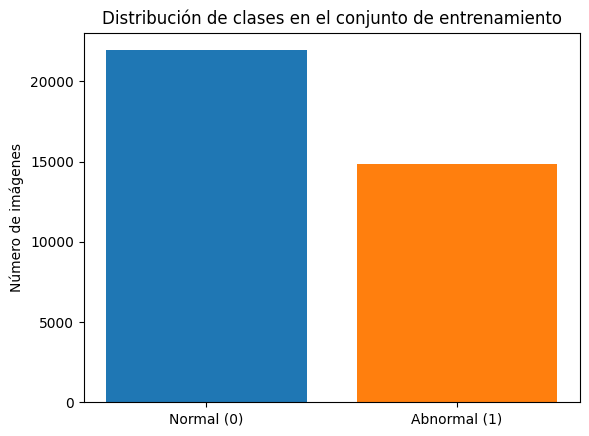


Pesos calculados para la función de pérdida: [1.6780487804878048, 2.4748201438848922]


In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Contar la cantidad de ejemplos por clase en el dataset de entrenamiento
# Esto permite detectar si hay desbalance entre clases (muy común en problemas médicos)
labels = [label for _, label in train_dataset]  # Extrae solo los labels (0 o 1)
label_counts = Counter(labels)  # Cuenta cuántas veces aparece cada clase

# Imprimir la distribución numérica por clase
print("Distribución de clases en el conjunto de entrenamiento:")
for clase, cantidad in label_counts.items():
    etiqueta = "Normal (0)" if clase == 0 else "Abnormal (1)"
    print(f"Clase {clase} ({etiqueta}): {cantidad} ejemplos")

# Visualización gráfica de la distribución
plt.bar(['Normal (0)', 'Abnormal (1)'], 
        [label_counts[0], label_counts[1]], 
        color=['#1f77b4', '#ff7f0e'])
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.ylabel("Número de imágenes")
plt.show()

# Calcular pesos de clase para la función de pérdida
# De esta forma, la clase menos representada tendrá un peso mayor
total = sum(label_counts.values())
class_weights = [total / label_counts[0], total / label_counts[1]]

# Convertimos los pesos a tensor y los enviamos al dispositivo adecuado (MPS)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Imprimir los pesos calculados, que se usarán en la función CrossEntropyLoss
print(f"\nPesos calculados para la función de pérdida: {class_weights}")

Uno de los principales retos al trabajar con datasets médicos como MURA es el **desbalance entre clases**. En este paso, analizamos la distribución de imágenes en el conjunto de entrenamiento y observamos que:

- **Clase 0 (Normal)** tiene 21,935 imágenes.
- **Clase 1 (Abnormal)** tiene 14,873 imágenes.

Esto implica que el modelo podría inclinarse a predecir la clase mayoritaria (Normal), lo cual sería perjudicial para la detección de casos anormales. 
Para mitigar este problema:

- Se calculan **pesos de clase** inversamente proporcionales a la frecuencia de cada clase, resultando en:

```python
Pesos para la función de pérdida: [1.678, 2.475]

## **Paso 5: Definición del modelo ResNet18 y descongelado parcial**

En este paso, se define el modelo de aprendizaje profundo basado en **ResNet18**, una red convolucional preentrenada en **ImageNet**.

Como estrategia de optimización, **descongelamos parcialmente** las capas desde `layer2` en adelante (`layer2`, `layer3`, `layer4` y `fc`).  
Esto permite que el modelo ajuste sus pesos en capas más profundas para aprender patrones más específicos del dominio de rayos X musculoesqueléticos, manteniendo congeladas las primeras capas que capturan patrones visuales más generales.

Además, se modifica la **capa final (`fc`)** del modelo para realizar **clasificación binaria**, distinguiendo entre radiografías **normales (0)** y **anormales (1)**.

In [5]:
# Cargar la arquitectura ResNet18 preentrenada con pesos de ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Descongelamos capas desde 'layer2' en adelante (layer2, layer3, layer4 y fc)
# Esto permite que las capas más profundas de la red se reajusten a nuestro problema específico (radiografías de extremidades)
# Las capas más bajas (como conv1 y layer1) permanecen congeladas, ya que aprenden características generales muy útiles (bordes, texturas, etc.)
for name, param in resnet18.named_parameters():
    if name.startswith('layer2') or name.startswith('layer3') or name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True  # Permitimos que estos pesos se actualicen durante el entrenamiento
    else:
        param.requires_grad = False  # Mantenemos congelados los pesos del resto (no se actualizan)

# Reemplazamos la capa final 'fc' (fully connected)
# La original está diseñada para clasificar entre 1000 clases de ImageNet, pero nosotros solo tenemos 2 clases: normal y abnormal
num_features = resnet18.fc.in_features  # Número de entradas que espera la capa final
resnet18.fc = nn.Linear(num_features, 2)  # Salida con 2 clases: 0 (normal) y 1 (abnormal)

# Enviamos el modelo al dispositivo de cómputo (MPS)
resnet18 = resnet18.to(DEVICE)

# Ver la arquitectura completa del modelo
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **Paso 6: Configuración del entrenamiento**

En este paso se define todo lo necesario para el entrenamiento del modelo:

- La **función de pérdida** (`CrossEntropyLoss`) adaptada al posible desbalance de clases usando pesos.
- El **optimizador** (`Adam`) que actualizará los pesos del modelo.
- Un **scheduler** (`ReduceLROnPlateau`) que reduce automáticamente la tasa de aprendizaje si el modelo deja de mejorar en validación.
- Parámetros de **early stopping** que interrumpen el entrenamiento si el modelo no mejora después de varios *epochs* consecutivos.

Esta configuración permite un entrenamiento más estable, eficiente y adaptado a las características del conjunto de datos.

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos de clase para abordar el desbalance de etiquetas
class_counts = [label for _, label in train_dataset]  # Extraemos todas las etiquetas del dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_counts), y=class_counts)
# Resultado: peso mayor para la clase minoritaria (para penalizar más sus errores)

# Convertimos los pesos a tensor de PyTorch y lo enviamos al dispositivo
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Definición de la función de pérdida (loss function)
# Usamos CrossEntropyLoss con pesos personalizados para que el modelo no ignore la clase minoritaria
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Definición del optimizador (Adam en este caso)
# Adam adapta automáticamente la tasa de aprendizaje para cada parámetro
# weight_decay añade regularización L2 para evitar sobreajuste
optimizer = optim.Adam(resnet18.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Configuración del scheduler (ReduceLROnPlateau)
# Reduce el learning rate a la mitad si la pérdida de validación no mejora durante cierto número de epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',            # Queremos minimizar la pérdida de validación
    factor=0.5,            # Reduce LR multiplicándolo por 0.5
    patience=LR_PATIENCE,  # Nº de epochs sin mejora antes de reducir LR
    verbose=True           # Muestra mensajes cuando el LR cambia
)

# Variables para controlar el early stopping manualmente
# Si el modelo no mejora tras varios epochs, detenemos el entrenamiento
best_val_loss = float('inf')  # Pérdida de validación más baja registrada
epochs_no_improve = 0         # Contador de epochs sin mejora

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### **Paso 7: Entrenamiento del modelo**

En este paso se entrena el modelo ResNet18 con las configuraciones previamente definidas.  
Se aplicará Early Stopping para evitar overfitting si la pérdida de validación no mejora durante `EARLYSTOP_PATIENCE` épocas.  
También se monitorizan métricas clave como la `accuracy`, el `F1-score`, y la pérdida (`loss`) tanto en entrenamiento como en validación.

Además, si se alcanza una mejor puntuación en validación, el modelo se guarda automáticamente.

In [ ]:
print("Comienza el entrenamiento...")

for epoch in range(NUM_EPOCHS):
    resnet18.train()  # Ponemos el modelo en modo entrenamiento
    train_loss = 0.0
    y_true, y_pred = [], []

    # Bucle sobre los batches del set de entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()  # Reseteamos los gradientes del optimizador
        outputs = resnet18(images)  # Hacemos predicciones con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida respecto a las etiquetas reales
        loss.backward()  # Calculamos los gradientes (backpropagation)
        optimizer.step()  # Actualizamos los pesos

        train_loss += loss.item() * images.size(0)  # Acumulamos pérdida total del batch

        _, preds = torch.max(outputs, 1)  # Obtenemos las clases predichas (mayor probabilidad)
        y_true.extend(labels.cpu().numpy())  # Guardamos etiquetas reales
        y_pred.extend(preds.cpu().numpy())   # Guardamos predicciones

    avg_train_loss = train_loss / len(train_loader.dataset)  # Pérdida media del entrenamiento

    # Validación (sin actualización de pesos)
    resnet18.eval()  # Ponemos el modelo en modo evaluación
    val_loss = 0.0
    val_true, val_pred = [], []

    with torch.no_grad():  # No calculamos gradientes (más rápido y eficiente)
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)  # Pérdida media de validación
    scheduler.step(avg_val_loss)  # Actualizamos el LR si la validación no mejora

    # Cálculo de métricas de validación
    acc = accuracy_score(val_true, val_pred)  # Exactitud
    f1 = f1_score(val_true, val_pred, average="binary")  # F1 para clasificación binaria

    # Imprimimos resultados de la época actual
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    # Guardado del mejor modelo (con menor val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(resnet18.state_dict(), MODEL_PATH)  # Guardamos el modelo
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLYSTOP_PATIENCE:  # Si no mejora durante N epochs, paramos
            print("Early stopping activado.")
            break

Comienza el entrenamiento...
Epoch 1 | Train Loss: 0.5380 | Val Loss: 0.5063 | Acc: 0.7707 | F1: 0.7402
Mejor modelo guardado.


## **Paso 8: Evaluación del modelo final**

En esta sección vamos a:
- Cargar el mejor modelo guardado durante el entrenamiento.
- Evaluarlo sobre el conjunto de validación.
- Generar el reporte de clasificación (precision, recall, F1-score, etc).
- Visualizar la matriz de confusión.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Cargar el mejor modelo guardado durante el entrenamiento
resnet18.load_state_dict(torch.load(MODEL_PATH))
resnet18.eval()  # Importante: modo evaluación desactiva dropout, batchnorm dinámica, etc.

# Evaluamos sobre el conjunto de validación
all_preds = []
all_labels = []

with torch.no_grad():  # No necesitamos gradientes en esta fase
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)  # Elegimos la clase con mayor probabilidad

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Reporte de métricas
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["negative", "positive"]))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

## **Paso 9: Guardado del modelo final**

Una vez que hemos evaluado el modelo y verificado su rendimiento, es hora de guardar sus pesos entrenados para su reutilización en producción o inferencia posterior.

El archivo se almacenará en la carpeta de modelos del proyecto. ("/src/models")

In [ ]:
import joblib
import os

# Ruta final donde se guardará el modelo entrenado
final_model_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model.joblib"

# Guardamos únicamente los pesos del modelo (state_dict)
# Joblib guarda objetos binarios, útil para modelos en producción
joblib.dump(resnet18.state_dict(), final_model_path)

print(f"Modelo guardado correctamente en: {final_model_path}")